In [31]:
# Locally defined imports
from src.utils import view_all_df
from src.training import MultiModelPipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix

# sklearn metrics and analysis
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import plot_partial_dependence

# sklearn preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import MissingIndicator

# sklearn model selection and pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# sklearn models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [65]:
X = pd.read_csv('../data/final_training_data.csv')

#### Create train and test split

In [66]:
n_test_data = 3
country_names = X['Country name'].unique()
test_countries = np.random.choice(country_names, size=n_test_data, replace=False)
XTest = X[X['Country name'].isin(test_countries)].reset_index(drop=True)
XTrain = X[~X['Country name'].isin(test_countries)].reset_index(drop=True)

X_test = XTest.iloc[:, 2:].values.astype('float')
y_test = XTest.values[:, 1].reshape(-1).astype('float')

In [67]:
X_train = XTrain.iloc[:, 2:].values.astype('float')
y_train = XTrain.values[:, 1].reshape(-1).astype('float')

In [68]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2038, 18) (47, 18) (2038,) (47,)


In [69]:
n_splits = 50
n_countries_per_split = 3

cv_splits = []

for split_idx in range(n_splits):
    split_countries = np.random.choice(XTrain['Country name'].unique(), size=n_countries_per_split, replace=False)
    val = XTrain[XTrain['Country name'].isin(split_countries)].index.values
    train = XTrain[~XTrain['Country name'].isin(split_countries)].index.values
    cv_splits.append((train, val))

#### Convert data to sparse matrices

In [70]:
X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)

#### Model predicting mean

In [71]:
mean_values = X.groupby('Country name').mean().loc[:, 'Ladder score']

In [72]:
temp = X.copy().loc[:, ['Country name', 'Ladder score']]
temp['pred'] = None
for idx in range(len(temp)):
    temp.iloc[idx, 2] = mean_values[temp.iloc[idx, 0]]
temp

,Country name,Ladder score,pred
0,Afghanistan,-1.577079,-1.76768
1,Afghanistan,-0.966851,-1.76768
2,Afghanistan,-0.646436,-1.76768
3,Afghanistan,-1.479874,-1.76768
4,Afghanistan,-1.523976,-1.76768
...,...,...,...
2080,Zimbabwe,-1.654482,-1.475824
2081,Zimbabwe,-1.674283,-1.475824
2082,Zimbabwe,-2.504122,-1.475824
2083,Zimbabwe,-2.084702,-1.475824


In [73]:
r2_score(temp['Ladder score'].values, temp['pred'].values)

0.8782711167902244

#### Training

In [74]:
pipeline_parameters = [
    {
        'estimator': [RandomForestRegressor()],
        'estimator__n_estimators': [100],
        'estimator__max_depth': [5]
    },
    {
        'estimator': [GradientBoostingRegressor()],
        'estimator__n_estimators': [100],
        'estimator__max_depth': [5]
    },
    {
        'estimator': [KNeighborsRegressor()],
        'estimator__n_neighbors': [10]
    },
    {
        'estimator': [SVR()],
        'estimator__kernel': ['rbf'],
        'estimator__gamma': ['auto']
    }
    ,
    {
        'estimator': [MLPRegressor(max_iter=20)],
        'estimator__hidden_layer_sizes': [(10, 5), (5)],
        'estimator__activation': ['logistic', 'relu']
    }
]

In [75]:
pipeline = MultiModelPipeline(parameters = pipeline_parameters, cv = cv_splits)

In [76]:
pipeline.fit(X_train, y_train)

Fitting 50 folds for each of 8 candidates, totalling 400 fits


In [77]:
pipeline.show_fit_results()

Best estimator is: 
{'estimator': SVR(gamma='auto'), 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf'}
Best estimator cross validation score is: 
0.22672906776834614


,rank_test_score,param_estimator,mean_fit_time,mean_test_score
0,2,RandomForestRegressor(),0.775132,0.204863
1,3,GradientBoostingRegressor(),0.834994,0.182142
2,4,KNeighborsRegressor(),0.001277,0.151536
3,1,SVR(gamma='auto'),0.239652,0.226729
4,8,MLPRegressor(max_iter=20),0.304332,-1.090663
5,6,MLPRegressor(max_iter=20),0.250758,-0.808050
6,5,MLPRegressor(max_iter=20),0.335636,0.073075
7,7,MLPRegressor(max_iter=20),0.236634,-0.963926


In [78]:
pipeline.show_scores( X_train, y_train, X_test, y_test)

For the best estimator:
Cross validation R2 score: 0.22672906776834614
Train score is: 0.22672906776834614
Cross validation score is: 0.22672906776834614
Training MSE: 0.1449965173336034
Training R2 score: 0.8550983743216151
Test MSE: 0.36262014230531975
Test R2 score: 0.3460082919453674


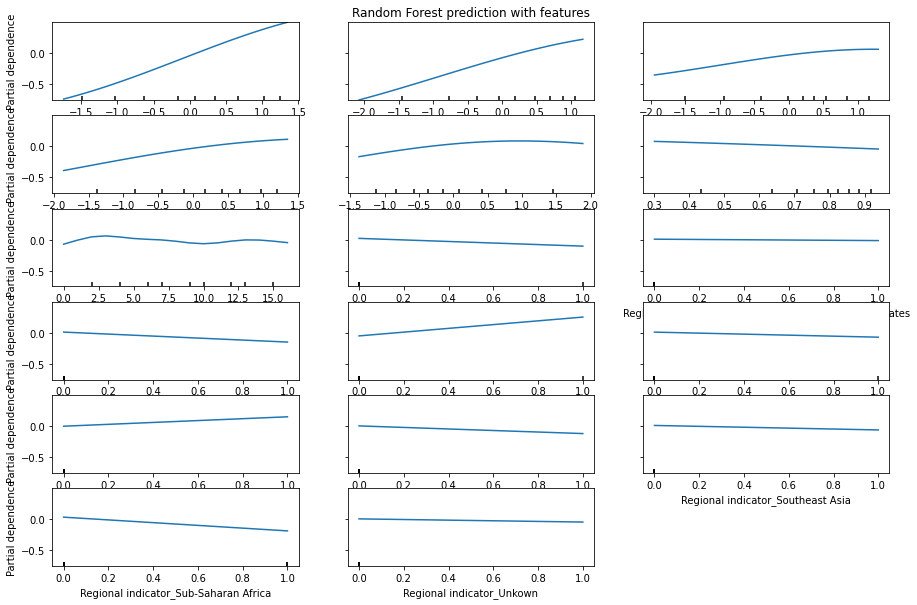

In [79]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Random Forest prediction with features')
ppd_plot = plot_partial_dependence(pipeline.model.best_estimator_, X_train.toarray(), range(X_train.shape[1]-1), feature_names = XTrain.columns[2:-1], ax=ax)
plt.show()

#### Error analysis

In [ ]:
temp = np.abs(y_train-y_pred)/y_train
error_df = pd.DataFrame(temp, columns=['error'])

error_df.loc[:, 'country'] = X.loc[:, 'Country name']
error_df.loc[:, 'year'] = X.loc[:, 'year'] + min_year
error_df = error_df.sort_values(by=['error'], ascending=False).reset_index(drop=True)
error_df

In [ ]:
plt.plot(error_df['error'].values)
plt.plot(error_df['error'].values[:100])

In [ ]:
temp1 = error_df.iloc[:100, :].groupby('country').count().loc[:, 'error'].sort_values(ascending=False)
temp2 = X.groupby('Country name').count().loc[:, 'year']
temp3 = pd.concat([temp1, temp2], axis=1)
temp3['diff'] = temp3['year']-temp3['error']
temp3.sort_values(by=['diff']).iloc[:50,:]

### Explain with LIME

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
X_train.shape

In [ ]:
X.columns[2:]

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                   feature_names=X.columns[2:],
                                                   categorical_features=[6],
                                                   verbose=True,
                                                   mode='regression')

#### Sri Lanka

In [ ]:
sri_lanka_index = X[X['Country name']=='Sri Lanka'].index[-1]

In [ ]:
exp = explainer.explain_instance(X_train[sri_lanka_index, :], cv_model.predict, num_features=5)

In [ ]:
y_train[sri_lanka_index]

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(X[X['Healthy life expectancy']>65.20].loc[:, 'Ladder score'], density=True)
plt.xlabel('Ladder Score')
plt.ylabel('Approx Density')
plt.title('Historgram of Ladder score for Healthy life expectancy > 65.20')
plt.show()

#### Syria

In [ ]:
syria_indices = XTrain['Country name']=='Sudan'

In [ ]:
syria_predict = cv_model.predict(X_train[syria_indices, :])
np.abs(y_train[syria_indices]-syria_predict)

In [ ]:
syria1, syria2 = 4,3
print(f'True = {y_train[[syria1,syria2]]}')
print(f'Predict = {syria_predict[[syria1,syria2]]}')

In [ ]:
exp = explainer.explain_instance(X_train[syria1, :], cv_model.predict, num_features=5)

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
exp = explainer.explain_instance(X_train[syria2, :], cv_model.predict, num_features=5)

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

In [ ]:
plt.hist(X[X['Healthy life expectancy']<58.30].loc[:, 'Ladder score'])
plt.show()

In [ ]:
plt.hist(X[X['Social support']<=0.74].loc[:, 'Ladder score'])
plt.show()

In [ ]:
plt.hist(X[X['Logged GDP per capita']<=8.4].loc[:, 'Ladder score'])
plt.show()